In [35]:
import numpy as np
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
class PrisonersDilemma:
    def __init__(self):
        # Actions: 0 for 'cooperate', 1 for 'defect'
        self.actions = [0, 1]
        # State is represented by the last action of each agent
        # Initialize state to (None, None)
        self.state = (None, None)

    def reset(self):
        # Reset the state at the start of each episode
        # Initialize with a default action (e.g., both players 'cooperate' initially)
        self.state = (0, 0)  # Instead of (None, None)
        return self.state

    def step(self, action1, action2):
        # Update state based on the agents' actions
        self.state = (action1, action2)

        # Reward structure
        if action1 == 0 and action2 == 0:
            reward1, reward2 = 3, 3
        elif action1 == 0 and action2 == 1:
            reward1, reward2 = 0, 5
        elif action1 == 1 and action2 == 0:
            reward1, reward2 = 5, 0
        elif action1 == 1 and action2 == 1:
            reward1, reward2 = 1, 1

        return self.state, (reward1, reward2)

In [37]:
# Example of using the environment
env = PrisonersDilemma()
for _ in range(5):  # Play 5 rounds
    state = env.reset()
    action1, action2 = np.random.choice(env.actions), np.random.choice(env.actions)
    next_state, reward = env.step(action1, action2)
    print(f"State: {state}, Actions: {action1}, {action2}, Next State: {next_state}, Reward: {reward}")

State: (0, 0), Actions: 0, 1, Next State: (0, 1), Reward: (0, 5)
State: (0, 0), Actions: 0, 1, Next State: (0, 1), Reward: (0, 5)
State: (0, 0), Actions: 1, 1, Next State: (1, 1), Reward: (1, 1)
State: (0, 0), Actions: 0, 1, Next State: (0, 1), Reward: (0, 5)
State: (0, 0), Actions: 1, 1, Next State: (1, 1), Reward: (1, 1)


In [38]:
class TitForTatAgent:
    def __init__(self):
        self.last_action = 0  # Tit for Tat starts by cooperating

    def step(self, opponent_last_action):
        # Tit for Tat strategy: replicate the opponent's last action
        if opponent_last_action is not None:
            self.last_action = opponent_last_action
        return self.last_action

In [39]:
class HoldsGrudgeAgent:
    def __init__(self):
        self.has_grudge = False  # Initially, the agent does not hold a grudge

    def step(self, opponent_last_action):
        # If the opponent has defected at least once, hold a grudge and always defect
        if opponent_last_action == 1:
            self.has_grudge = True
        return 1 if self.has_grudge else 0


In [40]:
class AlwaysCooperateAgent:
    def step(self, _):
        return 0  # Always cooperate


In [41]:
class AlwaysDefectAgent:
    def step(self, _):
        return 1  # Always defect

In [42]:
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x)

In [43]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [44]:
def select_action(state, q_network, epsilon, n_actions):
    if random.random() < epsilon:
        return random.choice(range(n_actions))
    else:
        with torch.no_grad():
            q_values = q_network(state)
            # Ensure q_values is a 1D tensor before calling max()
            return q_values.squeeze().max(0)[1].item()

In [45]:
def train(q_network, target_network, optimizer, replay_buffer, batch_size, gamma):
    if len(replay_buffer) < batch_size:
        return

    transitions = replay_buffer.sample(batch_size)

    # Unzip the transitions to separate lists
    batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)

    # Correctly prepare the batch of states
    batch_state = torch.stack([torch.Tensor(s[0]) for s in batch_state])
    batch_next_state = torch.stack([torch.Tensor(s[0]) for s in batch_next_state])

    batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(-1)
    batch_reward = torch.tensor(batch_reward, dtype=torch.float32).unsqueeze(-1)


    # Compute current Q values
    q_values = q_network(batch_state)
    # Ensure q_values is of shape [batch_size, number_of_actions]
    assert q_values.shape == (batch_size, 2), f"Unexpected shape of q_values: {q_values.shape}"

    current_q_values = q_values.gather(1, batch_action).squeeze(-1)

    # Compute next Q values from target network
    next_q_values = target_network(batch_next_state).max(1)[0]
    expected_q_values = (batch_reward + gamma * next_q_values).squeeze(-1)  # Make sure the dimensions match

    # Loss and optimization
    loss = nn.MSELoss()(current_q_values, expected_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [46]:
def update_target_network(q_network, target_network):
    target_network.load_state_dict(q_network.state_dict())

In [50]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99  # Discount factor for future rewards
batch_size = 32
replay_buffer_capacity = 10000
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
num_episodes = 3000  # Number of episodes to train
target_update_frequency = 10  # Update target network every 'n' episodes

# Environment setup
input_size = 2  # Assuming state is represented by the last action of each agent
output_size = 2  # Two possible actions: cooperate or defect

# Neural network setup
q_network = QNetwork(input_size, output_size)
target_network = QNetwork(input_size, output_size)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)

# Replay buffer
replay_buffer = ReplayBuffer(replay_buffer_capacity)

# Initialize epsilon for exploration-exploitation trade-off
epsilon = epsilon_start


In [51]:
episode_length = 100  # or any other appropriate number of rounds per episode


In [52]:
log_file_path = 'df.csv'  # Adjust the file path as needed

# Check if the log exists already, and if not, write the header
if not os.path.isfile(log_file_path):
    with open(log_file_path, mode='w', newline='') as file:
        log_writer = csv.writer(file)
        log_writer.writerow(['Episode', 'TimeStep', 'Agent_Action', 'Opponent_Action', 'Agent_Reward', 'Total_Reward'])

# Main training loop
for episode in range(num_episodes):
    state = env.reset()  # The state is the initial actions (0,0)
    total_reward = 0

    # Open the file in append mode to add to the logs
    with open(log_file_path, mode='a', newline='') as file:
        log_writer = csv.writer(file)

        for t in range(episode_length):
            state_tensor = torch.tensor([state], dtype=torch.float32)
            agent_action = select_action(state_tensor, q_network, epsilon, len(env.actions))
            opponent_action = np.random.choice(env.actions)  # Assuming a random opponent action for illustration
            next_state, (reward1, reward2) = env.step(agent_action, opponent_action)  # Get rewards from both actions

            total_reward += reward1  # Assuming you want to log the reward for agent 1

            # Write to the CSV file after each timestep
            log_writer.writerow([episode, t, agent_action, opponent_action, reward1, total_reward])



        next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
        replay_buffer.push(state_tensor,agent_action, reward[0], next_state_tensor)

        state = next_state

        # Train the network
        train(q_network, target_network, optimizer, replay_buffer, batch_size, gamma)

        # Update epsilon
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

    # Update target network every few episodes
        if episode % target_update_frequency == 0:
            update_target_network(q_network, target_network)

        print(f"Episode {episode}, Total Reward: {total_reward}")

# Save the trained model
torch.save(q_network.state_dict(), "q_network.pth")


Episode 0, Total Reward: 210
Episode 1, Total Reward: 261
Episode 2, Total Reward: 230
Episode 3, Total Reward: 240
Episode 4, Total Reward: 249
Episode 5, Total Reward: 191
Episode 6, Total Reward: 235
Episode 7, Total Reward: 234
Episode 8, Total Reward: 251
Episode 9, Total Reward: 219
Episode 10, Total Reward: 213
Episode 11, Total Reward: 182
Episode 12, Total Reward: 233
Episode 13, Total Reward: 236
Episode 14, Total Reward: 183
Episode 15, Total Reward: 241
Episode 16, Total Reward: 210
Episode 17, Total Reward: 203
Episode 18, Total Reward: 191
Episode 19, Total Reward: 240
Episode 20, Total Reward: 203
Episode 21, Total Reward: 247
Episode 22, Total Reward: 246
Episode 23, Total Reward: 208
Episode 24, Total Reward: 225
Episode 25, Total Reward: 222
Episode 26, Total Reward: 204
Episode 27, Total Reward: 231
Episode 28, Total Reward: 220
Episode 29, Total Reward: 211
Episode 30, Total Reward: 225
Episode 31, Total Reward: 207
Episode 32, Total Reward: 209
Episode 33, Total Re

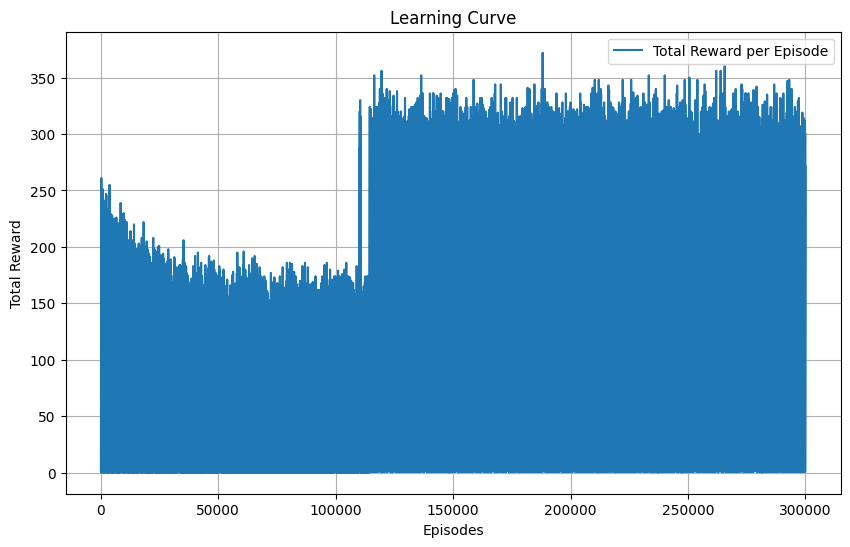

Average reward: 125.46993666666667
Standard deviation of rewards: 82.51073237019438
Max reward: 372
Min reward: 0
Average reward of the last 10% of episodes: 151.23063333333334


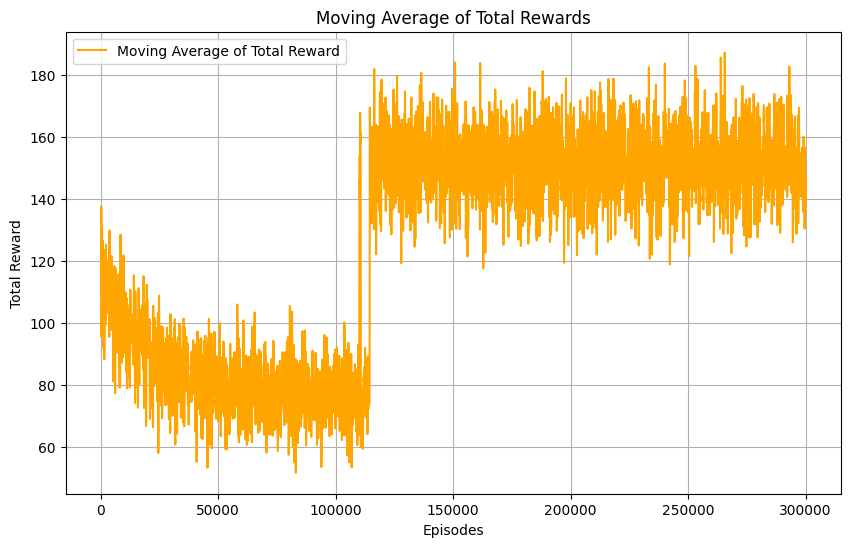

In [53]:
# Function to plot the learning curve
def plot_learning_curve(rewards_df, title="Learning Curve"):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards_df.index, rewards_df['Total_Reward'], label='Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Replace 'your_directory_path' with the actual directory path where your log.csv file is located

rewards_df = pd.read_csv('df.csv')

if rewards_df is not None:
    plot_learning_curve(rewards_df)

    # Calculate and print insights
    print(f"Average reward: {rewards_df['Total_Reward'].mean()}")
    print(f"Standard deviation of rewards: {rewards_df['Total_Reward'].std()}")
    print(f"Max reward: {rewards_df['Total_Reward'].max()}")
    print(f"Min reward: {rewards_df['Total_Reward'].min()}")

    # Assuming that the rewards are already summed up per episode in the 'Total Reward' column
    # Look for convergence in the last N episodes, where N could be 10% of the total episodes
    last_n = int(len(rewards_df) * 0.1)
    print(f"Average reward of the last 10% of episodes: {rewards_df['Total_Reward'][-last_n:].mean()}")

    # You could also calculate the moving average to see the trend more clearly
    rewards_df['Moving Average'] = rewards_df['Total_Reward'].rolling(window=100).mean()
    plt.figure(figsize=(10, 6))
    plt.plot(rewards_df.index, rewards_df['Moving Average'], label='Moving Average of Total Reward', color='orange')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Moving Average of Total Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

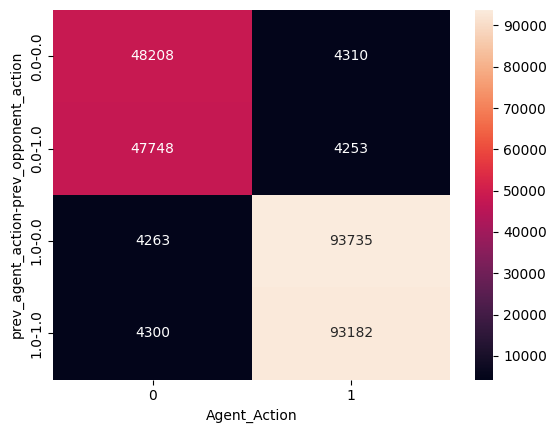

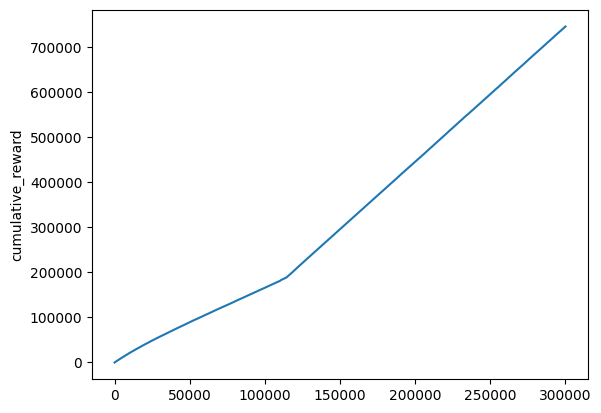

In [54]:
# Frequency Analysis of Actions
cooperation_count = rewards_df[rewards_df['Agent_Action'] == 0].shape[0]
defection_count = rewards_df[rewards_df['Agent_Action'] == 1].shape[0]

# State-Action Analysis
# This requires that 'prev_agent_action' and 'prev_opponent_action' are recorded in the DataFrame.
# If not, you will need to compute these from the current 'Agent_Action' and 'Opponent_Action'.
# For instance:
rewards_df['prev_agent_action'] = rewards_df['Agent_Action'].shift(1)
rewards_df['prev_opponent_action'] = rewards_df['Opponent_Action'].shift(1)

# Reward Analysis
# Group by the 'Agent_Action' to see which action gets more reward on average.
average_rewards = rewards_df.groupby('Agent_Action')['Agent_Reward'].mean()

# Transition Analysis
# You can create a transition matrix that shows the likelihood of transitioning to a particular
# next state given the current state and action.
transition_matrix = rewards_df.groupby(['prev_agent_action', 'prev_opponent_action', 'Agent_Action']).size().unstack(fill_value=0)

# Visualizations
# For visualizing the strategy, you can use heatmaps or line graphs.
# For instance, a heatmap of the transition matrix:
sns.heatmap(transition_matrix, annot=True, fmt='d')
plt.show()

# Or a line plot for the evolution of the reward:
rewards_df['cumulative_reward'] = rewards_df['Agent_Reward'].cumsum()
sns.lineplot(x=rewards_df.index, y=rewards_df['cumulative_reward'])
plt.show()

# For each of these analyses, you would replace the placeholder code with actual pandas operations
# that correspond to your DataFrame structure and the data you have collected.


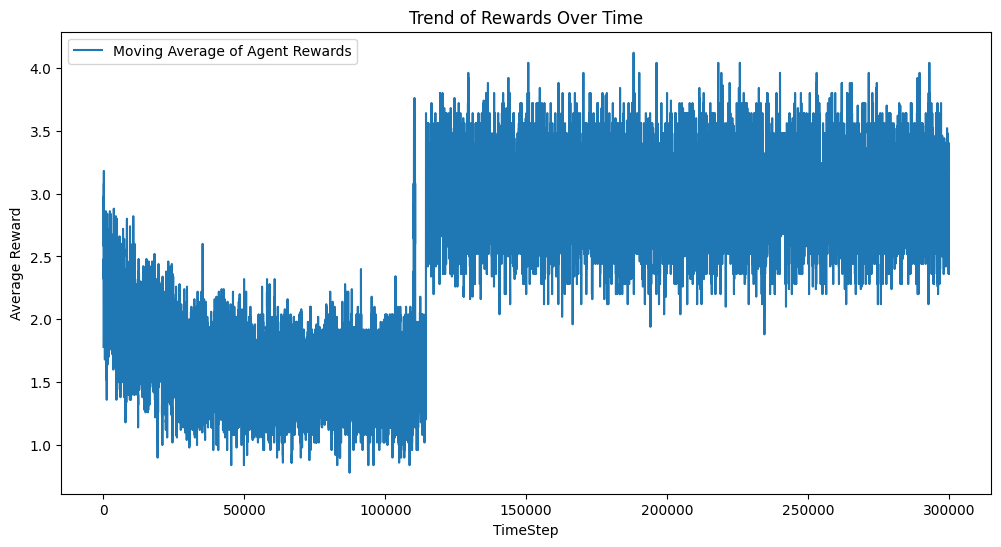

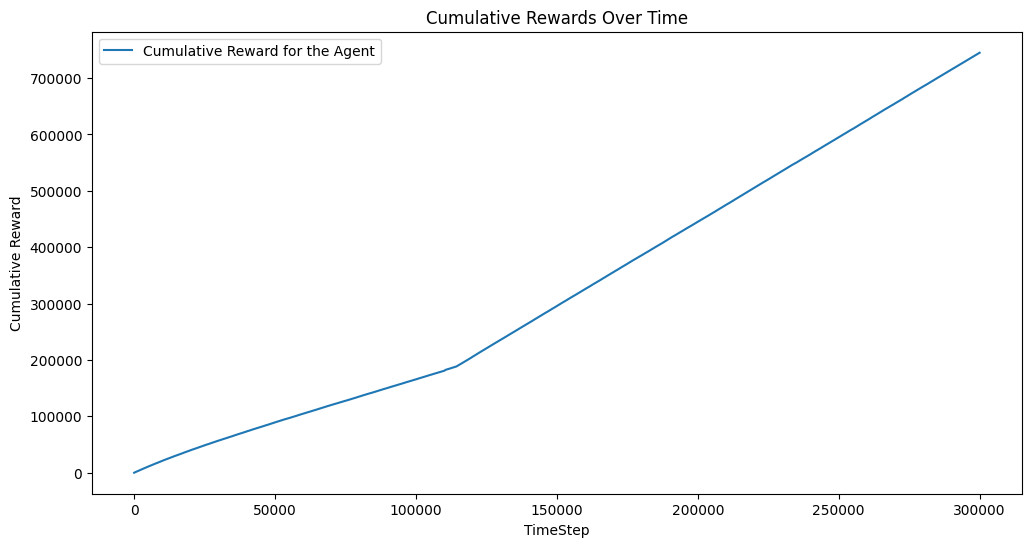

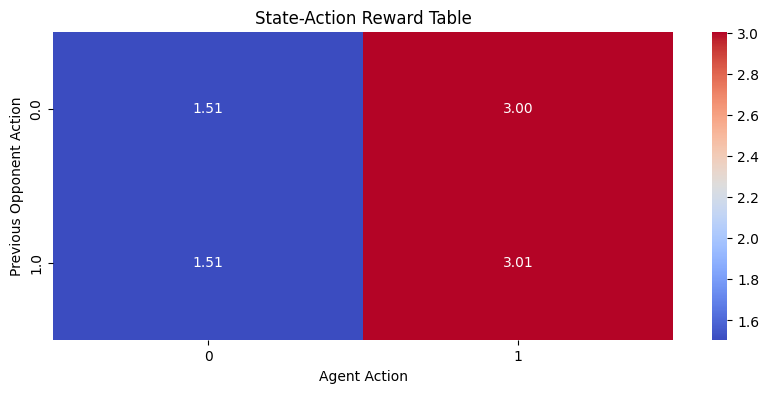

The agent has learned to defect on average.


In [56]:
# Assuming rewards_df is already loaded into your workspace.
# If not, you would load it like this:
# rewards_df = pd.read_csv('path_to_your_csv.csv')

# Analyze the frequency of each action
action_freq = rewards_df['Agent_Action'].value_counts(normalize=True)

# Calculate cumulative rewards for the agent to see the long-term trend
rewards_df['Cumulative_Reward'] = rewards_df['Agent_Reward'].cumsum()

# Calculate moving averages of the rewards for smoothing out the trends
rewards_df['Moving_Avg_Reward'] = rewards_df['Agent_Reward'].rolling(window=50).mean()  # Window size can be adjusted

# Visualizing the trend of rewards over time
plt.figure(figsize=(12, 6))
plt.plot(rewards_df['Moving_Avg_Reward'], label='Moving Average of Agent Rewards')
plt.xlabel('TimeStep')
plt.ylabel('Average Reward')
plt.title('Trend of Rewards Over Time')
plt.legend()
plt.show()

# Visualizing cumulative rewards over time
plt.figure(figsize=(12, 6))
plt.plot(rewards_df['Cumulative_Reward'], label='Cumulative Reward for the Agent')
plt.xlabel('TimeStep')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards Over Time')
plt.legend()
plt.show()

# Analyzing the strategy based on state-action pairs
# Assuming the state is represented by the last action of the opponent
rewards_df['Previous_Opponent_Action'] = rewards_df['Opponent_Action'].shift(1)  # Shift the opponent action to represent the previous state

# Create a state-action table
state_action_table = pd.pivot_table(rewards_df, values='Agent_Reward',
                                    index='Previous_Opponent_Action',
                                    columns='Agent_Action',
                                    aggfunc='mean').fillna(0)

# Visualize the state-action table as a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(state_action_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('State-Action Reward Table')
plt.xlabel('Agent Action')
plt.ylabel('Previous Opponent Action')
plt.show()

# Strategy Analysis
# Assuming action 0 is 'cooperate' and action 1 is 'defect'
cooperate_rewards = state_action_table.loc[:, 0]
defect_rewards = state_action_table.loc[:, 1]

strategy = 'cooperate' if cooperate_rewards.mean() > defect_rewards.mean() else 'defect'
print(f"The agent has learned to {strategy} on average.")

# Export the processed DataFrame with additional insights for further analysis if needed
rewards_df.to_csv('processed_rewards_df.csv', index=False)


In [59]:
print("Testing phase started.")

for test_episode in range(100):  # Define the number of test episodes
    # Initialize counters for each test episode
    cooperation_count = 0
    defection_count = 0
    response_to_cooperation = {'C': 0, 'D': 0}
    response_to_defection = {'C': 0, 'D': 0}

    state = env.reset()
    total_test_reward = 0
    total_opponent_reward = 0
    last_opponent_action = None  # Initialize last opponent action

    for t in range(episode_length):
        state_tensor = torch.tensor([state], dtype=torch.float32)
        test_action = select_action(state_tensor, q_network, 0.01, len(env.actions))
        opponent_action = np.random.choice(env.actions)
        next_state, (reward1, reward2) = env.step(test_action, opponent_action)

        total_test_reward += reward1
        total_opponent_reward += reward2
        state = next_state

        # Count cooperation and defection
        if test_action == 0:  # Assuming COOPERATE is defined as the corresponding action
            cooperation_count += 1
            if last_opponent_action == 0:
                response_to_cooperation['C'] += 1
            elif last_opponent_action == 1:  # Assuming DEFECT is defined
                response_to_defection['C'] += 1
        elif test_action == 1:
            defection_count += 1
            if last_opponent_action == 0:
                response_to_cooperation['D'] += 1
            elif last_opponent_action == 1:
                response_to_defection['D'] += 1

        last_opponent_action = opponent_action

          # Print the analysis
    print("Total Cooperations:", cooperation_count)
    print("Total Defections:", defection_count)
    print("Response to Opponent's Cooperation - Cooperate: {}, Defect: {}".format(response_to_cooperation['C'], response_to_cooperation['D']))
    print("Response to Opponent's Defection - Cooperate: {}, Defect: {}".format(response_to_defection['C'], response_to_defection['D']))

    # Determine and print the winner
    if total_test_reward > total_opponent_reward:
        winner = "DQN Agent"
    elif total_test_reward < total_opponent_reward:
        winner = "Random Agent"
    else:
        winner = "Tie"

    print(f"Test Episode {test_episode}, Total Test Reward (DQN): {total_test_reward}, Total Test Reward (Opponent): {total_opponent_reward}, Winner: {winner}")


Testing phase started.
Total Cooperations: 0
Total Defections: 100
Response to Opponent's Cooperation - Cooperate: 0, Defect: 48
Response to Opponent's Defection - Cooperate: 0, Defect: 51
Test Episode 0, Total Test Reward (DQN): 296, Total Test Reward (Opponent): 51, Winner: DQN Agent
Total Cooperations: 0
Total Defections: 100
Response to Opponent's Cooperation - Cooperate: 0, Defect: 54
Response to Opponent's Defection - Cooperate: 0, Defect: 45
Test Episode 1, Total Test Reward (DQN): 320, Total Test Reward (Opponent): 45, Winner: DQN Agent
Total Cooperations: 0
Total Defections: 100
Response to Opponent's Cooperation - Cooperate: 0, Defect: 50
Response to Opponent's Defection - Cooperate: 0, Defect: 49
Test Episode 2, Total Test Reward (DQN): 304, Total Test Reward (Opponent): 49, Winner: DQN Agent
Total Cooperations: 0
Total Defections: 100
Response to Opponent's Cooperation - Cooperate: 0, Defect: 48
Response to Opponent's Defection - Cooperate: 0, Defect: 51
Test Episode 3, Tot

In [64]:
log_file_path = 'titfortat.csv'

# Check if the log file exists already, and if not, write the header
if not os.path.isfile(log_file_path):
    with open(log_file_path, mode='w', newline='') as file:
        log_writer = csv.writer(file)
        log_writer.writerow(['Episode', 'TimeStep', 'Agent_Action', 'Opponent_Action', 'Agent_Reward', 'Total_Reward'])

# Main training loop
for episode in range(num_episodes):
    # Reinitialize the Tit for Tat agent at the start of each episode
    tit_for_tat_agent = TitForTatAgent()
    state = env.reset()
    total_reward = 0
    opponent_last_action = 0  # Track the last action of the opponent

    with open(log_file_path, mode='a', newline='') as file:
        log_writer = csv.writer(file)

        for t in range(episode_length):
            state_tensor = torch.tensor([state], dtype=torch.float32)
            agent_action = select_action(state_tensor, q_network, epsilon, len(env.actions))
            opponent_action = tit_for_tat_agent.step(opponent_last_action)  # Use Tit for Tat strategy

            next_state, (reward1, reward2) = env.step(agent_action, opponent_action)
            total_reward += reward1
            opponent_last_action = agent_action  # Update opponent's last action

            log_writer.writerow([episode, t, agent_action, opponent_action, reward1, total_reward])


            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
            replay_buffer.push(state_tensor, agent_action, reward1, next_state_tensor)
            state = next_state

        train(q_network, target_network, optimizer, replay_buffer, batch_size, gamma)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        if episode % target_update_frequency == 0:
            update_target_network(q_network, target_network)

        print(f"Episode {episode}, Total Reward: {total_reward}")

torch.save(q_network.state_dict(), "titfortat.pth")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 0, Total Reward: 299
Episode 1, Total Reward: 300
Episode 2, Total Reward: 300
Episode 3, Total Reward: 300
Episode 4, Total Reward: 299
Episode 5, Total Reward: 300
Episode 6, Total Reward: 300
Episode 7, Total Reward: 300
Episode 8, Total Reward: 269
Episode 9, Total Reward: 269
Episode 10, Total Reward: 269
Episode 11, Total Reward: 269
Episode 12, Total Reward: 269
Episode 13, Total Reward: 267
Episode 14, Total Reward: 267
Episode 15, Total Reward: 269
Episode 16, Total Reward: 269
Episode 17, Total Reward: 269
Episode 18, Total Reward: 266
Episode 19, Total Reward: 269
Episode 20, Total Reward: 269
Episode 21, Total Reward: 266
Episode 22, Total Reward: 266
Episode 23, Total Reward: 269
Episode 24, Total Reward: 269
Episode 25, Total Reward: 269
Episode 26, Total Reward: 299
Episode 27, Total Reward: 299
Episode 28, Total Reward: 300
Episode 29, Total Reward: 300
Episode 30, Total Reward: 300
Episode 31, Total Reward: 300
Episode 32, Total Reward: 300
Episode 33, Total Re

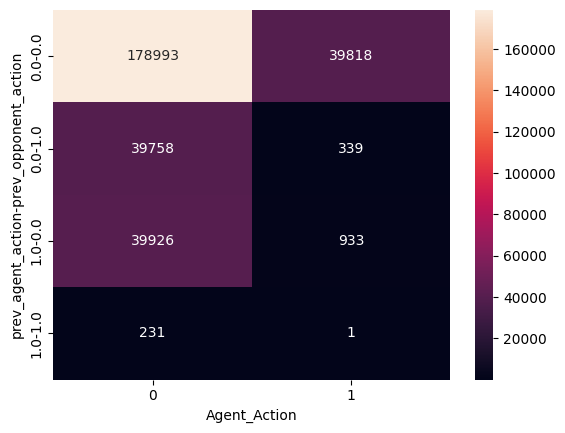

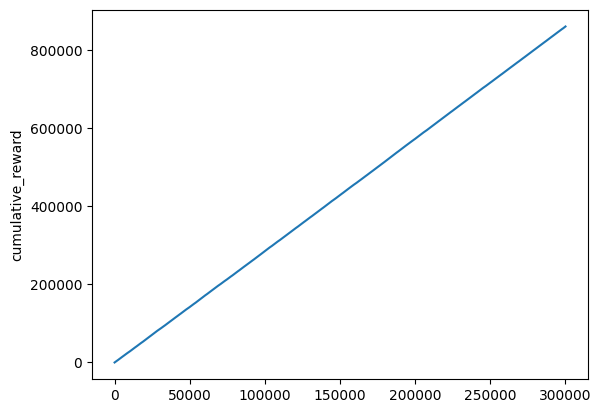

In [66]:
# Frequency Analysis of Actions
cooperation_count = rewards_df[rewards_df['Agent_Action'] == 0].shape[0]
defection_count = rewards_df[rewards_df['Agent_Action'] == 1].shape[0]

# State-Action Analysis
# This requires that 'prev_agent_action' and 'prev_opponent_action' are recorded in the DataFrame.
# If not, you will need to compute these from the current 'Agent_Action' and 'Opponent_Action'.
# For instance:
rewards_df['prev_agent_action'] = rewards_df['Agent_Action'].shift(1)
rewards_df['prev_opponent_action'] = rewards_df['Opponent_Action'].shift(1)

# Reward Analysis
# Group by the 'Agent_Action' to see which action gets more reward on average.
average_rewards = rewards_df.groupby('Agent_Action')['Agent_Reward'].mean()

# Transition Analysis
# You can create a transition matrix that shows the likelihood of transitioning to a particular
# next state given the current state and action.
transition_matrix = rewards_df.groupby(['prev_agent_action', 'prev_opponent_action', 'Agent_Action']).size().unstack(fill_value=0)

# Visualizations
# For visualizing the strategy, you can use heatmaps or line graphs.
# For instance, a heatmap of the transition matrix:
sns.heatmap(transition_matrix, annot=True, fmt='d')
plt.show()

# Or a line plot for the evolution of the reward:
rewards_df['cumulative_reward'] = rewards_df['Agent_Reward'].cumsum()
sns.lineplot(x=rewards_df.index, y=rewards_df['cumulative_reward'])
plt.show()

# For each of these analyses, you would replace the placeholder code with actual pandas operations
# that correspond to your DataFrame structure and the data you have collected.


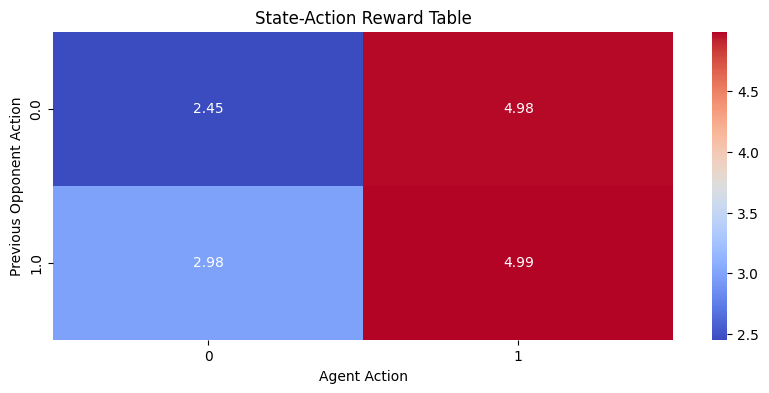

The agent has learned to defect on average.


In [69]:
# Assuming rewards_df is already loaded into your workspace.
# If not, you would load it like this:
# rewards_df = pd.read_csv('path_to_your_csv.csv')

# Analyze the frequency of each action
action_freq = rewards_df['Agent_Action'].value_counts(normalize=True)

# Calculate cumulative rewards for the agent to see the long-term trend
rewards_df['Cumulative_Reward'] = rewards_df['Agent_Reward'].cumsum()

# Calculate moving averages of the rewards for smoothing out the trends
rewards_df['Moving_Avg_Reward'] = rewards_df['Agent_Reward'].rolling(window=50).mean()  # Window size can be adjusted

# Analyzing the strategy based on state-action pairs
# Assuming the state is represented by the last action of the opponent
rewards_df['Previous_Opponent_Action'] = rewards_df['Opponent_Action'].shift(1)  # Shift the opponent action to represent the previous state

# Create a state-action table
state_action_table = pd.pivot_table(rewards_df, values='Agent_Reward',
                                    index='Previous_Opponent_Action',
                                    columns='Agent_Action',
                                    aggfunc='mean').fillna(0)

# Visualize the state-action table as a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(state_action_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('State-Action Reward Table')
plt.xlabel('Agent Action')
plt.ylabel('Previous Opponent Action')
plt.show()

# Strategy Analysis
# Assuming action 0 is 'cooperate' and action 1 is 'defect'
cooperate_rewards = state_action_table.loc[:, 0]
defect_rewards = state_action_table.loc[:, 1]

strategy = 'cooperate' if cooperate_rewards.mean() > defect_rewards.mean() else 'defect'
print(f"The agent has learned to {strategy} on average.")

# Export the processed DataFrame with additional insights for further analysis if needed
rewards_df.to_csv('processed_rewards_df.csv', index=False)


In [73]:
# Load the trained DQN model
q_network = QNetwork(input_size=2, output_size=2)
q_network.load_state_dict(torch.load("titfortat.pth"))
q_network.eval()  # Set the network to evaluation mode

# Prepare a DataFrame to store the results
results = []

for test_episode in range(100):  # Define the number of test episodes
    # Initialize the TitForTat agent and the environment

    cooperation_count = 0
    defection_count = 0
    response_to_cooperation = {'C': 0, 'D': 0}
    response_to_defection = {'C': 0, 'D': 0}

    tit_for_tat_agent = TitForTatAgent()
    state = env.reset()
    total_test_reward = 0
    total_opponent_reward = 0
    last_opponent_action = 0  # TitForTat starts by cooperating

    for t in range(episode_length):
        state_tensor = torch.tensor([state], dtype=torch.float32)
        test_action = select_action(state_tensor, q_network, 0.01, len(env.actions))
        opponent_action = tit_for_tat_agent.step(last_opponent_action)
        next_state, (reward1, reward2) = env.step(test_action, opponent_action)

        # Collect data
        results.append({
            'Episode': test_episode,
            'TimeStep': t,
            'Agent_Action': test_action,
            'Opponent_Action': opponent_action,
            'Agent_Reward': reward1,
            'Total_Reward': total_test_reward
        })

        total_test_reward += reward1
        total_opponent_reward += reward2
        state = next_state

                # Count cooperation and defection
        if test_action == 0:  # Assuming COOPERATE is defined as the corresponding action
            cooperation_count += 1
            if last_opponent_action == 0:
                response_to_cooperation['C'] += 1
            elif last_opponent_action == 1:  # Assuming DEFECT is defined
                response_to_defection['C'] += 1
        elif test_action == 1:
            defection_count += 1
            if last_opponent_action == 0:
                response_to_cooperation['D'] += 1
            elif last_opponent_action == 1:
                response_to_defection['D'] += 1

        last_opponent_action = test_action

    print("Total Cooperations:", cooperation_count)
    print("Total Defections:", defection_count)
    print("Response to Opponent's Cooperation - Cooperate: {}, Defect: {}".format(response_to_cooperation['C'], response_to_cooperation['D']))
    print("Response to Opponent's Defection - Cooperate: {}, Defect: {}".format(response_to_defection['C'], response_to_defection['D']))


    # Determine and print the winner
    if total_test_reward > total_opponent_reward:
        winner = "DQN Agent"
    elif total_test_reward < total_opponent_reward:
        winner = "TFT Agent"
    else:
        winner = "Tie"

    print(f"Test Episode {test_episode}, Total Test Reward (DQN): {total_test_reward}, Total Test Reward (Opponent): {total_opponent_reward}, Winner: {winner}")

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save the DataFrame to an Excel file
df.to_excel("test_results.xlsx", index=False)

print("Results saved to test_results.xlsx.")

Total Cooperations: 100
Total Defections: 0
Response to Opponent's Cooperation - Cooperate: 100, Defect: 0
Response to Opponent's Defection - Cooperate: 0, Defect: 0
Test Episode 0, Total Test Reward (DQN): 300, Total Test Reward (Opponent): 300, Winner: Tie
Total Cooperations: 98
Total Defections: 2
Response to Opponent's Cooperation - Cooperate: 96, Defect: 2
Response to Opponent's Defection - Cooperate: 2, Defect: 0
Test Episode 1, Total Test Reward (DQN): 298, Total Test Reward (Opponent): 298, Winner: Tie
Total Cooperations: 98
Total Defections: 2
Response to Opponent's Cooperation - Cooperate: 96, Defect: 2
Response to Opponent's Defection - Cooperate: 2, Defect: 0
Test Episode 2, Total Test Reward (DQN): 298, Total Test Reward (Opponent): 298, Winner: Tie
Total Cooperations: 98
Total Defections: 2
Response to Opponent's Cooperation - Cooperate: 97, Defect: 1
Response to Opponent's Defection - Cooperate: 1, Defect: 1
Test Episode 3, Total Test Reward (DQN): 297, Total Test Reward